# Damped spring-mass system with kalman estimator
This case consists in :

* a LTI system, named *sys* `blocksim.control.System.LTISystem`

  This element simulates the system

* a LQ regulator, named *ctl* `blocksim.control.Controller.LQRegulator`

  This element compares the estimated state of the system and compares to the setpoint.
  It controls the system so that it reaches the setpoint

* a noisy biased sensor, named *cpt* `blocksim.control.Sensors.LinearSensors`

  This element measures the position with noise and a constant bias

* a Kalman filter , named *kal* `blocksim.control.Estimator.TimeInvariantKalmanFilter`

  This version of the Kalman filter is the steady-state version : the matrix gain and state covariance matrix are fix in time.

* a LQ regulator, named *ctl* `blocksim.control.Controller.LQRegulator`

  This element compares the estimated state of the system and compares to the setpoint.
  It controls the system so that it reaches the setpoint

* a setpoint, named *stp* `blocksim.control.SetPoint.Step`
  This element provides a user command such as a step or a ramp or a Dirac, ...
  Here, we will use a unit step function

In [1]:
%matplotlib inline
import numpy as np

## Definition of the system
Mass, spring and friction

In [2]:
from blocksim.control.System import LTISystem

m = 1.0  # Mass
k = 40.0  # Spring rate
f = 5

sys = LTISystem("sys", shape_command=(1,), snames_state=["x", "v"])
sys.matA = np.array([[0, 1], [-k / m, -f / m]])
sys.matB = np.array([[0, 1 / m]]).T
# We set the initial position to -1, and the initial velocity to 0
sys.setInitialStateForOutput(np.array([-1.0, 0.0]), "state")

[INFO] - Registered blocksim.loggers.CSVLogger
[INFO] - Registered blocksim.loggers.PickleLogger
[INFO] - Registered blocksim.loggers.PsqlLogger
[INFO] - Registered blocksim.loggers.XlsLogger


## Definition of the Kalman filter, with converged gain matrix
The state vector of the Kalman filter includes the bias of the position sensor

In [3]:
from blocksim.control.Estimator import TimeInvariantKalmanFilter

kal = TimeInvariantKalmanFilter(
    "kal",
    shape_cmd=(1,),  # Shape of the command vector
    snames_state=["x", "v", "b"],  # Components of the state vector
    snames_output=["x"],  # Components of the output vector
)
kal.matA = np.zeros((3, 3))
kal.matA[:2, :2] = sys.matA
kal.matB = np.zeros((3, 1))
kal.matB[:2] = sys.matB
kal.matC = np.array([[1, 0, 1]])
kal.matD = np.zeros((1, 1))
kal.matQ = np.eye(3) / 10000
kal.matR = np.eye(1) / 100

## Definition of a noisy biased sensor
The sensor measures the position

In [4]:
from blocksim.control.Sensors import LinearSensors

bias = 0.5

cpt = LinearSensors("cpt", shape_state=(2,), shape_command=(1,), snames=["x"])
cpt.matC = np.array([1, 0])
cpt.matD = np.zeros((1, 1))
cpt.setCovariance(np.eye(1) / 200)
cpt.setMean(np.array([bias]))

## Definition of a LQ regulator
The controller determines the command

In [5]:
from blocksim.control.Controller import LQRegulator

ctl = LQRegulator("ctl", shape_setpoint=(1,), shape_estimation=(2,), snames=["u"])
ctl.matA = sys.matA
ctl.matB = sys.matB
ctl.matC = kal.matC[:, :2]
ctl.matD = kal.matD
ctl.matQ = np.eye(2) / 10000
ctl.matR = np.eye(1) / 100
ctl.computeGain()

## Definition of the setpoint : unit step function
The setpoint is simple Heavyside function here

In [6]:
from blocksim.control.SetPoint import Step

stp = Step(name="stp", snames=["c"], cons=np.array([1]))

## Definition of a splitter
The Kalman's state vector is x, v, b.
But the controller expects an estimation of the system's state vector.
So we need a splitter wich excludes the bias estimation

In [7]:
from blocksim.control.Route import Split

spt_otp = dict()
spt_otp["split"] = [0, 1]  # We keep outputs 0 and 1 of the input vector
split = Split("split", signal_shape=(3,), outputs=spt_otp)

## Simulation
### Simulation setup

In [8]:
from blocksim.Simulation import Simulation

sim = Simulation()

sim.addComputer(sys)
sim.addComputer(ctl)
sim.addComputer(cpt)
sim.addComputer(kal)
sim.addComputer(split)
sim.addComputer(stp)

# List of the connnections
sim.connect("stp.setpoint", "ctl.setpoint")
sim.connect("ctl.command", "sys.command")
sim.connect("sys.state", "cpt.state")
sim.connect("ctl.command", "cpt.command")
sim.connect("cpt.measurement", "kal.measurement")
sim.connect("ctl.command", "kal.command")
sim.connect("kal.state", "split.signal")
sim.connect("split.split", "ctl.estimation")

### Running the simulation and plotting

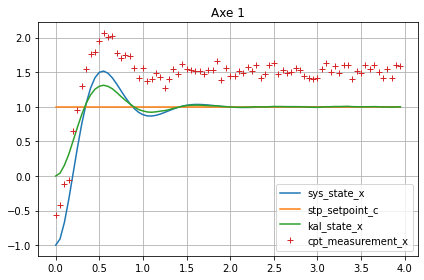

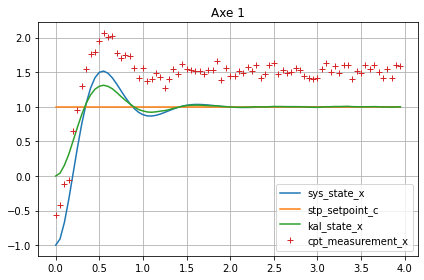

In [9]:
dt = 0.05

tps = np.arange(0, 4, dt)
sim.simulate(tps, progress_bar=False)

log = sim.getLogger()

from blocksim.graphics import plotVerif
from matplotlib import pyplot as plt

plotVerif(
    log,
    "test_ss_kal",
    [
        {"var": "sys_state_x"},
        {"var": "stp_setpoint_c"},
        {"var": "kal_state_x"},
        {"var": "cpt_measurement_x", "linestyle": "", "marker": "+"},
    ],
)